# Notebook to Analyze the Efficacy of Generative Models for Anomaly Detection

In this notebook we will look to use different generative models on graphs to learn distributions over normal graphs and hopefully detect some anomalies. We specifically start our experimentation looking at the GraphRNN framework implemented by the SNAP group

In [1]:
# Fun some setup for the project
# Silence annoying pytorch deprecated warnings
import warnings
warnings.filterwarnings("ignore")
# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from train import *
from create_graphs import *
%matplotlib inline

print ('CUDA Available:', torch.cuda.is_available())

CUDA Available: True


In [2]:
# Generate the model datasets (i.e. the dataset used to train
# the model - normal data)
args_enzy, train_enzy, val_enzy, test_enzy = get_graph_data("enzymes", isModelDataset=True)
# Save the max_previous node to allow for model 
# compatability on future datasets
max_prev_node = args_enzy.max_prev_node

Loading graph dataset: ENZYMES
Loaded
Average num nodes 33.030664395229984
total graph num: 587
max number node: 125
max/min number edge: 149; 16
max previous node: 25


In [3]:
# Initialize the dataset and dataloader for analyzing the nlls. 
# Note that we use batch_size = 1 because we want the nll for each
# data point not an average across a batch.
# We should also consider using Graph_sequence_Sampler_pytorch_nll.
# This sampler expands the size of the dataset by for each graph 
# creating many different bfs permutations. The idea behind this sampler
# is to test the models permutation invariance. 

train_dataset = Graph_sequence_sampler_pytorch_rand(train_enzy,max_prev_node=args_enzy.max_prev_node,max_num_node=args_enzy.max_num_node)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=args_enzy.num_workers)

test_dataset = Graph_sequence_sampler_pytorch_rand(test_enzy, max_prev_node=args_enzy.max_prev_node,max_num_node=args_enzy.max_num_node)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=args_enzy.num_workers)



In [4]:
# Model initialization
# Using GraphRNN

rnn = GRU_plain(input_size=args_enzy.max_prev_node, embedding_size=args_enzy.embedding_size_rnn,
                        hidden_size=args_enzy.hidden_size_rnn, num_layers=args_enzy.num_layers, has_input=True,
                        has_output=True, output_size=args_enzy.hidden_size_rnn_output).to(device)
output = GRU_plain(input_size=1, embedding_size=args_enzy.embedding_size_rnn_output,
                        hidden_size=args_enzy.hidden_size_rnn_output, num_layers=args_enzy.num_layers, has_input=True,
                        has_output=True, output_size=1).to(device)

In [5]:
# Let's do some analysis on the training data
nlls, avg_nlls = calc_nll(args_enzy, train_loader, rnn, output, max_iter=20)
#plt.xlim([0, 55])

./model_save/GraphRNN_RNN_enzymes_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 10
Average Nll over train data: 68.54987822107668
Iteration: 20
Average Nll over train data: 68.87713432820367


In [20]:
avg_nlls_iter = np.array(avg_nlls)
avg_nlls_iter = avg_nlls_iter.reshape((20, len(train_loader)))
avg_nlls_iter = np.mean(avg_nlls_iter, axis=0)

In [6]:
def compare_dist(nlls, labels=['Nomarl', 'Anomalous'], title="Normal vs. Anomalous NLL Distributions"):
    fig, ax = plt.subplots()
    for i in range(len(nlls)):
        sns.distplot(nlls[i], ax=ax, kde=True, label=labels[i])
    ax.legend()
    ax.set_xlabel("Negative Log Likelihood")
    ax.set_title(title)
    return fig, ax

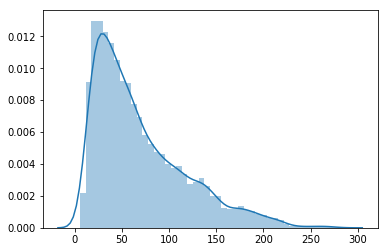

In [7]:
# Plot un averaged nlls (over the feature dimensions of the graph sequence) for the model's training dataset
plt.figure()
sns.distplot(nlls,kde=True)

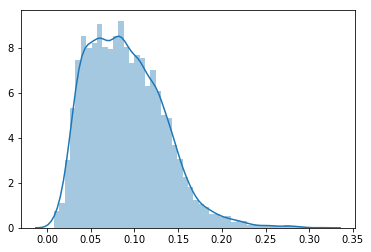

In [8]:
# Plot averaged nlls (over the feature dimensions of the graph sequence) for the model's training dataset
plt.figure()
sns.distplot(avg_nlls,kde=True)

In [9]:
# Analysis of the test data set nlls.
test_nlls, test_avg_nlls = calc_nll(args_enzy, test_loader, rnn, output, max_iter=20)

./model_save/GraphRNN_RNN_enzymes_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 10
Average Nll over train data: 88.9456279560671
Iteration: 20
Average Nll over train data: 85.84294051639104


In [23]:
test_avg_nlls_iter = np.array(test_avg_nlls)
test_avg_nlls_iter = test_avg_nlls_iter.reshape((20, len(test_loader)))
test_avg_nlls_iter = np.mean(test_avg_nlls_iter, axis=0)

Text(0.5,1,'NLL summed across features')

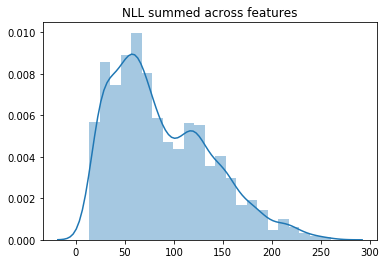

In [10]:
# Un-averaged nlls over the test normal distribution
plt.figure()
sns.distplot(test_nlls, kde=True)
plt.title('NLL summed across features')

Text(0.5,1,'NLL averaged across features')

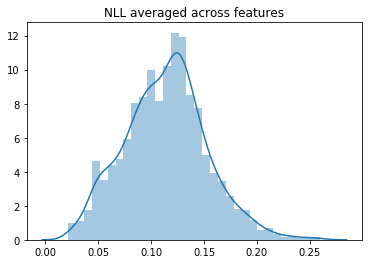

In [11]:
# Averaged nlls over test normal distribution
plt.figure()
sns.distplot(test_avg_nlls, kde=True)
plt.title('NLL averaged across features')

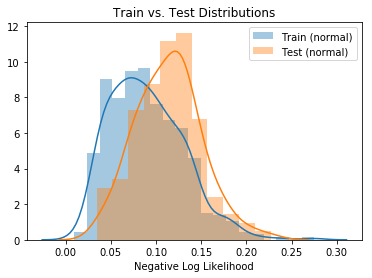

In [24]:
fig, ax_compare = compare_dist([avg_nlls_iter, test_avg_nlls_iter], 
                               ['Train (normal)', 'Test (normal)'],
                              'Train vs. Test Distributions')
fig.savefig("NLL_Figures/Train_Test_Enzyme")

In [12]:
# Now let's try using a different dataset on the same GraphRNN
# trained on the enzyemes small dataset. By plotting the distribution
# over the nlls of this test set from a different family, hopefully
# we can see the success of the generative model
args_ladder, graphs_ladder = get_graph_data("ladder_small", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
ladder_dataset = Graph_sequence_sampler_pytorch_rand(graphs_ladder,max_prev_node=max_prev_node,max_num_node=args_ladder.max_num_node)
ladder_loader = torch.utils.data.DataLoader(ladder_dataset, batch_size=1, num_workers=args_ladder.num_workers)

Average num nodes 12.0
total graph num: 9
max number node: 20
max/min number edge: 28; 4
max previous node: 10


In [13]:
# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
ladder_nlls, ladder_avg_nlls = calc_nll(args_enzy, ladder_loader, rnn, output, max_iter=100, train_dataset="enzymes")

./model_save/GraphRNN_RNN_enzymes_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 10
Average Nll over train data: 29.692316585116917
Iteration: 20
Average Nll over train data: 31.486342006259495
Iteration: 30
Average Nll over train data: 31.69825055864122
Iteration: 40
Average Nll over train data: 31.642916467454697
Iteration: 50
Average Nll over train data: 32.427147229512535
Iteration: 60
Average Nll over train data: 32.878581047058105
Iteration: 70
Average Nll over train data: 30.806164741516113
Iteration: 80
Average Nll over train data: 32.25821993086073
Iteration: 90
Average Nll over train data: 32.61962371402316
Iteration: 100
Average Nll over train data: 33.49473942650689


In [26]:
ladder_avg_nlls_iter = np.array(ladder_avg_nlls)
ladder_avg_nlls_iter = ladder_avg_nlls_iter.reshape((100, len(ladder_loader)))
ladder_avg_nlls_iter = np.mean(ladder_avg_nlls_iter, axis=0)

Text(0.5,1,'NLL summed over the features')

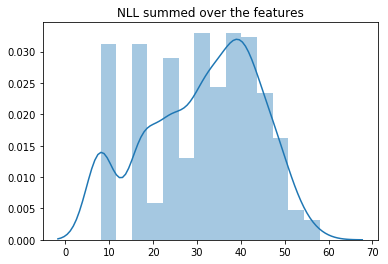

In [14]:
# Un-averaged nlls over the ladder normal distribution
plt.figure()
sns.distplot(ladder_nlls, kde=True)
plt.title("NLL summed over the features")

900


Text(0.5,1,'NLL averaged across features')

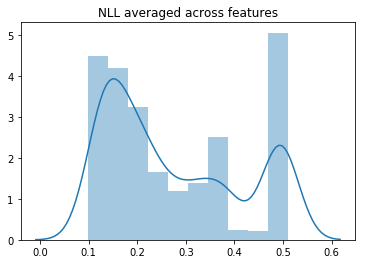

In [15]:
# Averaged nlls over the ladder normal distribution
plt.figure()
sns.distplot(ladder_avg_nlls, kde=True, bins=10)
print (len(ladder_avg_nlls))
plt.title('NLL averaged across features')

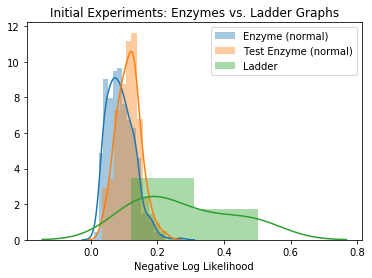

In [32]:
fig, ax_compare = compare_dist([avg_nlls_iter, test_avg_nlls_iter, ladder_avg_nlls_iter], 
                               ['Enzyme (normal)', "Test Enzyme (normal)", "Ladder"], 
                              'Initial Experiments: Enzymes vs. Ladder Graphs')
fig.savefig("NLL_Figures/Enzyme-Vs-Ladder")

In [16]:
# Now let's try using a different dataset on the same GraphRNN
# trained on the enzyemes small dataset. By plotting the distribution
# over the nlls of this test set from a different family, hopefully
# we can see the success of the generative model
args_caveman, graphs_caveman = get_graph_data("caveman_small", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
caveman_dataset = Graph_sequence_sampler_pytorch_rand(graphs_caveman,max_prev_node=max_prev_node,max_num_node=args_caveman.max_num_node)
caveman_loader = torch.utils.data.DataLoader(caveman_dataset, batch_size=1, num_workers=args_caveman.num_workers)

Average num nodes 16.0
total graph num: 100
max number node: 20
max/min number edge: 82; 20
max previous node: 20


In [17]:
# Let's see how the nlls of the caveman graphs compare to 
# the trained on enzymes
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
caveman_nlls, caveman_avg_nlls = calc_nll(args_enzy, caveman_loader, rnn, output, train_dataset="enzymes")

./model_save/GraphRNN_RNN_enzymes_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 10
Average Nll over train data: 84.13983121871948
Iteration: 20
Average Nll over train data: 84.93264944076537
Iteration: 30
Average Nll over train data: 85.10571044921875
Iteration: 40
Average Nll over train data: 83.48857307434082
Iteration: 50
Average Nll over train data: 84.41925886154175
Iteration: 60
Average Nll over train data: 84.62910982131957
Iteration: 70
Average Nll over train data: 83.25515832901002
Iteration: 80
Average Nll over train data: 84.22170907974242
Iteration: 90
Average Nll over train data: 83.556595993042
Iteration: 100
Average Nll over train data: 83.89740266799927


In [29]:
caveman_avg_nlls_iter = np.array(caveman_avg_nlls)
caveman_avg_nlls_iter = caveman_avg_nlls_iter.reshape((100, len(caveman_loader)))
caveman_avg_nlls_iter = np.mean(caveman_avg_nlls_iter, axis=0)

Text(0.5,1,'NLL summed over the features')

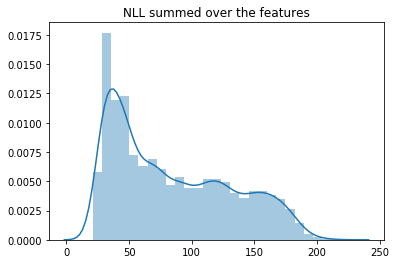

In [18]:
# Un-averaged nlls over the caveman normal distribution
plt.figure()
sns.distplot(caveman_nlls, kde=True)
plt.title("NLL summed over the features")

Text(0.5,1,'NLL averaged across features')

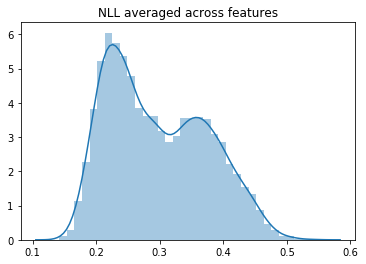

In [19]:
# Averaged nlls over the caveman normal distribution
plt.figure()
sns.distplot(caveman_avg_nlls, kde=True)
plt.title('NLL averaged across features')

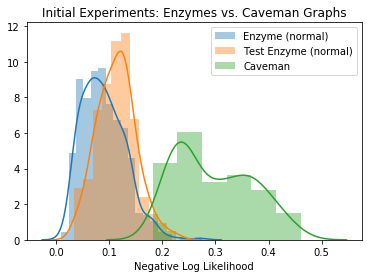

In [31]:
fig, ax_compare = compare_dist([avg_nlls_iter, test_avg_nlls_iter, caveman_avg_nlls_iter], 
                               ['Enzyme (normal)', "Test Enzyme (normal)", "Caveman"], 
                              'Initial Experiments: Enzymes vs. Caveman Graphs')
fig.savefig("NLL_Figures/Enzyme-Vs-Caveman")